# MulticlassSN10 development

In [1]:
from pathlib import Path
import re
from typing import List
import json
import numpy as np
import pandas as pd
# import dovpanda
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
# import mlflow

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import NegativeClassOptimization.config as config
import NegativeClassOptimization.utils as utils
import NegativeClassOptimization.datasets as datasets
import NegativeClassOptimization.preprocessing as preprocessing
import NegativeClassOptimization.ml as ml

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
N = 100
NUM_CLASSES = 6

Define the dataset

In [3]:
# TODO: Add a label - Ag map! To log with mlflow later.

dfs = utils.load_processed_dataframes()
df = dfs["train_val"].sample(N).reset_index(drop=True)
print(f"{df.columns=}")

df = preprocessing.onehot_encode_df(df)

arr = preprocessing.arr_from_list_series(df["Slide_onehot"])
scaler = StandardScaler()
scaler.fit(arr)
arr = scaler.transform(arr)
# TODO: note scaling leaks to test set

antigens = df["Antigen"].unique().tolist()
encoder = LabelEncoder().fit(antigens)

df["X"] = arr.tolist()
df["y"] = encoder.transform(df["Antigen"])

df[["X", "y"]].head(3)

df.columns=Index(['Unnamed: 0.1', 'Unnamed: 0', 'ID_slide_Variant', 'CDR3', 'Best',
       'Slide', 'Energy', 'Structure', 'UID', 'Antigen',
       'Slide_farmhash_mod_10'],
      dtype='object')


,X,y
0,"[2.7080128015453186, -0.5619514869490159, 0.0,...",1
1,"[-0.369274472937998, 1.779513042005217, 0.0, -...",3
2,"[-0.369274472937998, -0.5619514869490159, 0.0,...",2


In [4]:
def construct_dataset_loader(df: pd.DataFrame):
    dataset = datasets.MulticlassDataset(df)
    loader = DataLoader(
        dataset=dataset,
        batch_size=10,
        shuffle=False,
    )
    return dataset, loader    


df_train = df[["X", "y"]].sample(int(0.7*N))
df_test = df.loc[~df.index.isin(df_train.index)].copy()

train_dataset, train_loader = construct_dataset_loader(df_train.reset_index(drop=True))
test_dataset, test_loader = construct_dataset_loader(df_test.reset_index(drop=True))
open_dataset, open_loader = preprocessing.construct_open_dataset_loader(
    dfs["test_open_exclusive"].sample(int(N*4)).reset_index(drop=True),
    batch_size=10,
    scaler=scaler
)

Define the model

In [5]:
model = ml.MulticlassSN10(num_classes=NUM_CLASSES)
y_pred = model.forward(torch.Tensor(df["X"]))
print(f"{y_pred.shape=}")

y_true = torch.Tensor(df["y"]).type(torch.long)
print(f"{y_true.shape=}")

loss = nn.CrossEntropyLoss()(y_pred, y_true)
print(f"{loss=}")

y_pred.shape=torch.Size([100, 6])
y_true.shape=torch.Size([100])
loss=tensor(1.8176, grad_fn=<NllLossBackward0>)


Train

In [6]:
# TODO: add online metrics

loss_fn = nn.CrossEntropyLoss()
optimizer = ml.construct_optimizer(
    optimizer_type="Adam",
    learning_rate=0.01,
    momentum=0.9,
    weight_decay=0,
    model=model,
)

online_metrics_per_epoch = []
for t in range(10):
    print(f"Epoch {t+1}\n-------------------------------")
    losses = ml.train_loop(train_loader, model, loss_fn, optimizer)
    # TODO: test_metrics = ml.test_loop(test_loader, model, loss_fn)
    # TODO: open_metrics = ml.openset_loop(open_loader, test_loader, model)
    online_metrics_per_epoch.append({
            "train_losses": losses,
            # "test_metrics": test_metrics,
            # "open_metrics": open_metrics,
        })

Epoch 1
-------------------------------
loss: 1.836646  [    0/   70]
Epoch 2
-------------------------------
loss: 1.333343  [    0/   70]
Epoch 3
-------------------------------
loss: 1.039355  [    0/   70]
Epoch 4
-------------------------------
loss: 0.753531  [    0/   70]
Epoch 5
-------------------------------
loss: 0.530035  [    0/   70]
Epoch 6
-------------------------------
loss: 0.392182  [    0/   70]
Epoch 7
-------------------------------
loss: 0.295859  [    0/   70]
Epoch 8
-------------------------------
loss: 0.213415  [    0/   70]
Epoch 9
-------------------------------
loss: 0.157795  [    0/   70]
Epoch 10
-------------------------------
loss: 0.116125  [    0/   70]


Metrics:
- one vs rest (OVR) approach is preferred -- done
- F1 -- done
- ROC PR
    - average precision only for multilabel and binary, not multiclass problems.
- Kohen's kappa
    - Not relevant for us: The function cohen_kappa_score computes Cohen’s kappa statistic. This measure is intended to compare labelings by different human annotators, not a classifier versus a ground truth.
- MCC -- done
- confusion matrix -- done
- classification_report -- done

sklearn has the metrics that are required.

In [7]:
# TODO: add this as separate func
x_test, y_test = list(DataLoader(test_loader.dataset, batch_size=len(test_loader.dataset)))[0]

# fetch avg loss from the other func
# TODO

# ~ multiclass version of compute_metrics_closed_testset 
y_test_pred_logits = model.forward(x_test).detach().numpy()
y_test_pred_prob = model.forward_prob(x_test).detach().numpy()
y_test_pred = y_test_pred_prob.argmax(axis=1)
metrics_closed = {
    "acc_closed": metrics.accuracy_score(y_test, y_test_pred),
    "acc_balanced_closed": metrics.balanced_accuracy_score(y_test, y_test_pred),

    **{
        f"{str(func).split(' ')[1].split('_')[0]}_{str(avg_type)}_closed": func(
            y_test, 
            y_test_pred, 
            average=avg_type
            )
        for func in {
            metrics.f1_score, 
            metrics.precision_score, 
            metrics.recall_score,
            }
        for avg_type in {"micro", "macro", "weighted", None}
    },

    **{
        f"roc_auc_{avg_type}_closed": metrics.roc_auc_score(
            y_test, 
            y_test_pred_prob, 
            average=avg_type,
            multi_class="ovr",
            )
        for avg_type in {"macro", "weighted", None}
    },

    "confusion_matrix_normed_closed": metrics.confusion_matrix(y_test, y_test_pred),
    "mcc_closed": metrics.matthews_corrcoef(y_test, y_test_pred),
}
metrics_closed

{'acc_closed': 0.4,
 'acc_balanced_closed': 0.3972222222222222,
 'precision_macro_closed': 0.37777777777777777,
 'precision_None_closed': array([0.33333333, 0.5       , 0.6       , 0.33333333, 0.5       ,
        0.        ]),
 'precision_micro_closed': 0.4,
 'precision_weighted_closed': 0.43333333333333335,
 'recall_macro_closed': 0.3972222222222222,
 'recall_None_closed': array([0.33333333, 0.75      , 0.3       , 0.5       , 0.5       ,
        0.        ]),
 'recall_micro_closed': 0.4,
 'recall_weighted_closed': 0.4,
 'f1_macro_closed': 0.37222222222222223,
 'f1_None_closed': array([0.33333333, 0.6       , 0.4       , 0.4       , 0.5       ,
        0.        ]),
 'f1_micro_closed': 0.4000000000000001,
 'f1_weighted_closed': 0.39333333333333337,
 'roc_auc_macro_closed': 0.6732237258626149,
 'roc_auc_None_closed': array([0.75308642, 0.75      , 0.58      , 0.60416667, 0.67307692,
        0.67901235]),
 'roc_auc_weighted_closed': 0.6471201329534664,
 'confusion_matrix_normed_closed':

Open set classification with MulticlassSN10


In [8]:
# TODO: add pred and eval on open set
ml.openset_loop(open_loader, test_loader, model)

{'y_open_abs_logits': array([ 7.7658906 ,  2.9532835 ,  4.976025  ,  4.478628  ,  9.444641  ,
         5.497519  ,  7.874886  ,  3.7259028 , 11.247861  ,  3.5865455 ,
         4.5035605 ,  7.6758976 ,  5.2317    ,  7.5456924 ,  5.88175   ,
         2.0042155 ,  2.0973265 ,  7.4185996 ,  2.3344343 ,  4.7991667 ,
         4.942945  ,  6.5602903 ,  6.0855665 ,  4.829858  ,  5.2253785 ,
         2.0330408 ,  8.030176  , 12.104701  ,  2.6740243 ,  7.661266  ,
        10.621866  ,  6.4732823 ,  5.6479206 ,  7.658215  ,  4.3780704 ,
         4.7537026 ,  0.9162084 ,  0.7004853 ,  5.2071652 ,  5.5698614 ,
         0.31472105,  3.938212  ,  2.2066534 ,  4.0672417 ,  3.2885985 ,
         5.0227027 ,  0.31472105,  7.794289  ,  1.5533086 ,  8.166443  ,
         3.9138649 ,  1.7389042 ,  5.8340364 ,  3.7881293 ,  0.31472105,
         2.8489811 ,  2.762638  ,  8.4917755 ,  1.9729731 ,  4.6065593 ,
         2.3307638 ,  0.8617852 ,  1.0491167 ,  5.6307735 ,  5.9122725 ,
         4.1359434 ,  5.985060

Other artifacts: plots, text, dicts, etc.

- {precision_recall,roc}_curve work only in binary.

In [9]:
# TODO: save as text?
print(metrics.classification_report(y_test, y_test_pred, target_names=encoder.classes_))

              precision    recall  f1-score   support

        1FBI       0.33      0.33      0.33         3
        1NSN       0.50      0.75      0.60         4
        1OB1       0.60      0.30      0.40        10
        1WEJ       0.33      0.50      0.40         6
        3VRL       0.50      0.50      0.50         4
        5E94       0.00      0.00      0.00         3

    accuracy                           0.40        30
   macro avg       0.38      0.40      0.37        30
weighted avg       0.43      0.40      0.39        30



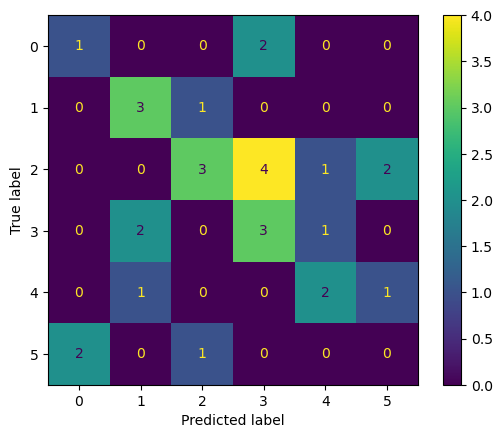

In [10]:
# TODO: Do the plots!

## PR, ROC, logit distributions

## Confusion
cm = metrics.confusion_matrix(y_test, y_test_pred)
disp = metrics.ConfusionMatrixDisplay(cm)
disp.plot()
# TODO: add normed